In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.insert(0, '..')

import random
from itertools import combinations

import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

import altair as alt

from paradeller.helper import load_archive, comma_print
from paradeller.samples import load_samples
from paradeller.analysis import (
    find_duplicates,
    filter_out_duplicates,
    filter_out_oddballs,
    restructure_data,
    find_matches,
    find_matches_for_start_pairs
)

In [3]:
def get_tweet(i):
    """Find tweet with given id"""
    try:
        return next(x for x in data if x["id"] == i)
    except StopIteration as e:
        print("Error: No tweet with that ID")
        return None

## Get Data

In [19]:
data = load_archive()
comma_print(len(data))

156,374


In [21]:
sample_data = load_samples()

####################
# USE SAMPLE DATA??
#
# data = sample_data
#
####################

In [213]:
# remove duplicate phrases
duplicates = find_duplicates(data)
data = filter_out_duplicates(data, duplicates)
comma_print(len(data))

99,269


In [214]:
# remove oddballs (too few matches)
data = filter_out_oddballs(data)
comma_print(len(data))

69,527


In [215]:
# make adj lists
adj_list_words, adj_list_ids = restructure_data(data)

## Optimizations

In [217]:
ids = list(adj_list_ids.keys())
comma_print(len(ids))

69,527


In [222]:
some_ids = [
    random.choice(ids)
    for _ in range(100)
]

pairs = list(combinations(some_ids, 2))
comma_print(len(pairs))

45


In [224]:
def find_matches_for_pair(p):
    return find_matches(p[0], p[1], adj_list_ids, adj_list_words)

### Arrays

In [228]:
import scipy.sparse as sp

In [229]:
from scipy.sparse import dok_matrix

In [238]:
x = len(adj_list_ids.keys())
y = len(adj_list_words.keys())

In [268]:
ids = np.array(list(adj_list_ids.keys()))

In [269]:
words = np.array(list(adj_list_words.keys()))

In [275]:
S = dok_matrix((len(ids), len(words)), dtype=np.bool)

In [278]:
for i in range(len(ids)):
    for j in range(len(words)):
        val = ids[i] in adj_list_words[words[j]]
        S[i, j] = val

KeyboardInterrupt: 

In [221]:
with Pool(os.cpu_count()) as pool:
    res = pool.map(find_matches_for_pair, pairs)

Process ForkPoolWorker-1459:


KeyboardInterrupt: 

In [220]:
# start pairs should have no common words

# def no_common_words(pair):    
#     s1 = set(adj_list_ids[pair[0]])
#     s2 = set(adj_list_ids[pair[1]])
#     return len(s1.intersection(s2)) == 0

# pairs = [p for p in pairs if no_common_words(p)]
comma_print(len(pairs))

44,850


In [145]:
all_valid = find_matches_for_start_pairs(pairs, adj_list_ids, adj_list_words)

In [216]:
len(all_valid)

14

### Parallel

In [201]:
from math import sqrt
from joblib import Parallel, delayed

In [202]:
some_ids = [
    random.choice(ids)
    for _ in range(1000)
]

some_ids = ids

pairs = list(combinations(some_ids, 2))
comma_print(len(pairs))

1,035


In [203]:
from multiprocessing import Pool
import os

In [204]:
def find_matches_for_pair(p):
    return find_matches(p[0], p[1], adj_list_ids, adj_list_words)

In [205]:
%%timeit

with Pool(os.cpu_count()) as pool:
    res = pool.map(find_matches_for_pair, pairs)

148 ms ± 8.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [206]:
%%timeit

res = [find_matches_for_pair(p) for p in pairs]

38.2 ms ± 6.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [186]:
all_valid = [x for x in list(zip(pairs, res)) if x[1]]

In [192]:
for pair, matches in all_valid:
    t1, t2 = pair
    stanza_start = [t1, t1, t2, t2]
    for match in matches:
        a, b = match
        stanza = stanza_start + [a, b]
        print("~"*50)
        for t in stanza:
            tweet = get_tweet(t)
            print(f"@{tweet['author']:20} {tweet['text']} ")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
@unknown              fall into this faulty trap of myself 
@unknown              fall into this faulty trap of myself 
@unknown              explain me without understanding why 
@unknown              explain me without understanding why 
@unknown              explain this faulty trap of myself fall 
@unknown              into understanding why without me 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
@unknown              explain this faulty trap of myself fall 
@unknown              explain this faulty trap of myself fall 
@unknown              into understanding why without me 
@unknown              into understanding why without me 
@unknown              fall into this faulty trap of myself 
@unknown              explain me without understanding why 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
@unknown              buries your sadness in my abstraction 
@unknown              buries your sadness in my abstraction 
@unkn

In [170]:
res = [find_matches_for_pair(p) for p in pairs]

In [171]:
[x for x in res if x]

[[(10, 11)],
 [(6, 8)],
 [(16, 17)],
 [(12, 14)],
 [(28, 29)],
 [(24, 26)],
 [(34, 35)],
 [(30, 32)],
 [(40, 41)],
 [(36, 38)],
 [(52, 53)],
 [(48, 50)],
 [(64, 65)],
 [(60, 62)]]

In [ ]:
%%timeit

with Pool(os.cpu_count()) as pool:
    res = pool.map(find_matches_for_pair, pairs)

In [118]:
%%timeit

res = [find_matches_for_pair(p) for p in pairs]

27.7 s ± 3.02 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [116]:
# Parallel(n_jobs=2)(delayed(find_matches)(
#     p[0], p[1], adj_list_ids, adj_list_words
# ) for p in tqdm(pairs))

### Timing

Timing

- Takes ~73 ms

In [55]:
avg_run_ms = 73

res = []
for num_ids in tqdm([10, 100, 200, 500, 1000, 2000, 5000, 10_000]):
    some_ids = [
        random.choice(ids)
        for _ in range(num_ids)
    ]
    pairs = list(combinations(some_ids, 2))
    total_ms = len(pairs) * avg_run_ms
    seconds = total_ms / 1000
    
    res.append((num_ids, len(pairs), seconds))

In [56]:
df = pd.DataFrame(res, columns=['ids', 'pairs', 'seconds'])
df['hours'] = df['seconds'] / 60 / 60
df

,ids,pairs,seconds,hours
0,10,45,3.285,0.000913
1,100,4950,361.350,0.100375
2,200,19900,1452.700,0.403528
3,500,124750,9106.750,2.529653
4,1000,499500,36463.500,10.128750
5,2000,1999000,145927.000,40.535278
6,5000,12497500,912317.500,253.421528
7,10000,49995000,3649635.000,1013.787500


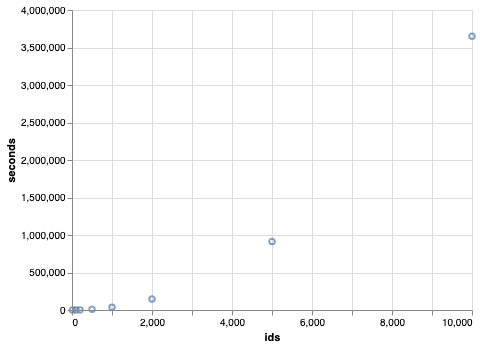

In [57]:
alt.Chart(df).mark_point().encode(
    x='ids',
    y='seconds'
)

In [124]:
some_pairs = [random.choice(pairs) for _ in range(10)]

In [123]:
d = {}

def timed(pair):
    a, b = pair
    res = %timeit -o find_matches(a, b, adj_list_ids, adj_list_words)
    d[pair] = (res.average * 1000)

In [117]:
# for p in tqdm(some_pairs):
#     timed(p)

In [88]:
df = pd.DataFrame(list(d.items()), columns=['pair', 'ms'])

In [91]:
df.describe()

,time (ms)
count,30.000000
mean,73.722072
std,33.391046
min,15.139419
25%,49.510464
50%,75.178153
75%,95.398927
max,149.660940


In [112]:
pair = df.sort_values(by='time (ms)').tail(1).pair.iloc[0]
pair

(1144711620683341824, 1144364140410146818)

In [115]:
a, b = pair

In [116]:
find_matches(a, b, adj_list_ids, adj_list_words, verbose=True)

stanza words : ['could', 'has', 'have', 'i', 'my', 'never', 'notifications', 'on', 'paige', 'to', 'work', 'you']
pot_ids      : 36183
filt pot_ids : 1


[]

In [55]:
a, b = random.choice(pairs)

In [70]:
res = %timeit -o find_matches(a, b, adj_list_ids, adj_list_words)

55.2 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [74]:
res.average

0.05515330764285733

In [75]:
0.05515330764285733 * 1000

55.15330764285733

In [73]:
res.a

Type:        property
String form: <property object at 0x102d16408>
Docstring:   <no docstring>


In [27]:
a, b = pairs[0]

In [44]:
print(adj_list_ids[a])
print(adj_list_ids[b])

['enough', 'is', 'enough', 'fam']
['i', 'fucking', 'suck']


In [45]:
valid = find_matches(a, b, adj_list_ids, adj_list_words, verbose=True)
valid

stanza words : ['enough', 'enough', 'fam', 'fucking', 'i', 'is', 'suck']
pot_ids      : 25971
filt pot_ids : 0


[]